## AB testing

* https://en.wikipedia.org/wiki/A/B_testing
* https://www.kaggle.com/tammyrotem/ab-tests-with-python 
* https://www.udacity.com/course/ab-testing--ud257 (Udacity course)
* https://www.optimizely.com/optimization-glossary/ab-testing/ -> a tool for website optimisation

TLDR: a simple controlled experiment

A/B testing is a way to compare two versions of a single variable, typically by testing a subject's response to variant A against variant B, and determining which of the two variants is more effective.
 
* Use case on a website: By randomly serving visitors two versions of a website that differ only in the design of a single button element, the relative efficacy of the two designs can be measured.
* Use case on an e-commerce website: the purchase funnel is typically a good candidate for A/B testing, as even marginal decreases in drop-off rates can represent a significant gain in sales

The benefits of A/B testing are considered to be that it can be performed continuously on almost anything, especially since most marketing automation software now typically comes with the ability to run A/B tests on an ongoing basis.

Results must be statistically significant: that is, highly likely that the differences are real, repeatable, and not due to random chance

## Bayesian AB testing
https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a
    
Let’s introduce the sample data: we already run an A/B test for checking the Conversion Rate (CR, since now on) of a web page, and the results are in the Table below.

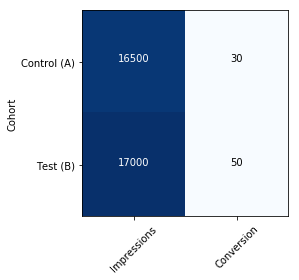

In [1]:
from IPython.display import Image
Image("ab.png")

In [2]:
#This is the known data: imporessions and conversions for the Control and Test set
imps_ctrl, convs_ctrl=16500, 30 
imps_test, convs_test=17000, 50

In [3]:
from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [4]:
from scipy.stats import beta
import numpy as np

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

In [5]:
#calculating the probability for Test to be better than Control
prob=calc_prob_between(beta_T, beta_C)

print (f"Test option lift Conversion Rates by {lift*100:2.2f}% with {prob*100:2.1f}% probability.")

#output: Test option lift Conversion Rates by 59.68% with 98.2% probability.

Test option lift Conversion Rates by 59.68% with 98.2% probability.


.

The Test option performs much better than the Control one: almost 60% uplift, with more than 98% probability of being better.

As you can see, these are bare, agnostic, results. Wether they are good or not depends on your situation. Anything above 95% should be good enough.

The CR are modelled as [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). How is this justified? The answer lies in a nicety of the Bayes theorem. A/B tests are random experiments with exactly two possible outcomes, “convert” or “don’t”, and as such is described as a Bernoulli trial, and the Beta distribution is the conjugate prior for such a process. 

Distributions plotted below:

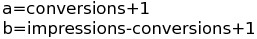

In [9]:
Image("beta-dist-factors.png")

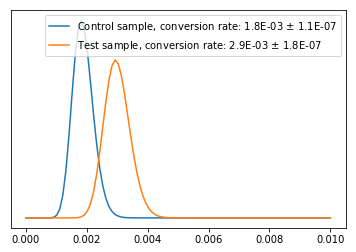

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def calc_beta_mode(a, b):
    '''this function calculate the mode (peak) of the Beta distribution'''
    return (a-1)/(a+b-2)

def plot(betas, names, linf=0, lsup=0.01):
    '''this function plots the Beta distribution'''
    x=np.linspace(linf,lsup, 100)
    for f, name in zip(betas,names) :
        y=f.pdf(x) #this for calculate the value for the PDF at the specified x-points
        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # the variance of the Beta distribution
        plt.plot(x,y, label=f"{name} sample, conversion rate: {y_mode:0.1E} $\pm$ {y_var:0.1E}")
        plt.yticks([])
    plt.legend()
    plt.show()

plot([beta_C, beta_T], names=["Control", "Test"]);

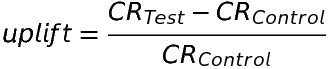

In [8]:
Image("uplift.png")

But, at this point, you need to asses how trustful is this result. Note that, in the classical, “frequentist”, paradigm you have no way of calculate such probability. In that approach, you usually calculate the ‘p-value’, and then check whether or not it falls under an arbitrarily chosen threshold (‘α value’, typically 5%), and eventually you can declare something almost impossible to explain to any manager/client/board: “with 95% confidence level, we can reject the null hypothesis”. And then, you have to explain that this declaration is very different from “this hypothesis is better then the other with 95% probability”, which is the very sentence they really want to hear from you.

But here we are in the **bayesian world**, and here we can actually say that. In fact, we have PDFs which define our CR, and the probability is given by the area under the curve. This is, practically, the definition of PDF.

A simple example: do you want the probability for the Test option’s CR to be greater than, say, 0.003? Well, it’s just the area under the Test curve between 0.003 and 1.0, which is shaded in the Figure below:

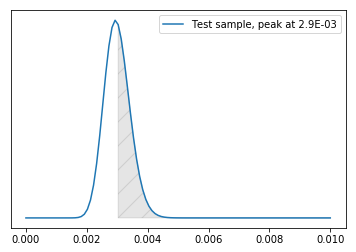

In [10]:
Image("PDF.png")

Calculate the area by integrate over the curve between the two limits: 0.003 (the limit that we choose) and 1 (the hard limit). With Python, we can calculate this integral exactly:

In [11]:
from mpmath import betainc

p=betainc(a_T, b_T, 0.003,1, regularized=True) #result: 0.48112566853812544

In [12]:
p

mpf('0.48112566853812544')

In this example we considered only one distribution (the Test one), but to measure the trustefulness of our uplift we have to consider both the distributions (Control and Test), and so in order to visualize the situation we have to add a dimension. By consequence, the probability we are going to measure is is defined not by an area anymore, but by a volume instead. In particular, the volume under the joint probability distribution of Test and Control where the Test is greater than the Control. Let’s see what it is (takes a LONG time to run):

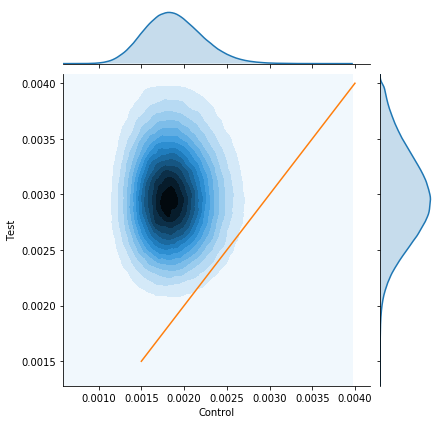

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
imps_ctrl,convs_ctrl=16500, 30 
imps_test, convs_test=17000, 50

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

val_C=np.random.beta(a_C, b_C, 1000000)
val_T=np.random.beta(a_T, b_T, 1000000)
vals=np.vstack([val_C, val_T]).T

limit=0.004


df=pd.DataFrame(vals, columns=['Control', 'Test'])
df=df[df['Control']<limit]
df=df[df['Test']<limit]
g=sns.jointplot(x=df.Control, y=df.Test, kind='kde', n_levels=15)
g.ax_joint.plot([0.0015, limit], [0.0015, limit])

To calculate this volume (in the upper triangle of Figure 4), I saw a lot of posts around the web which, again, use approximated methods (like Monte Carlo). Well, the people who wrote them are not aware that an exact method has already been deployed by John Cook in 2005 (chapter 2). The code within the module calc_prob.py reproduces that formulation, and comes almost in full from a version originally wrote by Antti Rasinen.

In our case the area is 0.98, which means that the ‘Test’ option performs better than the ‘Control’ one with 98% probability.

the code on this page has become the baseline of an A/B testing tool which work with [Mixpanel](https://mixpanel.com/)